In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import stock_function as stock

%matplotlib inline
plt.style.use("fivethirtyeight")

In [14]:
#Load stock data
company = "BTC-USD"
start = dt.date(2015, 1, 1)
end = dt.date.today()

df = web.DataReader(company, "yahoo", start, end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999
...,...,...,...,...,...,...
2022-03-31,47512.027344,45390.539062,47062.148438,45538.675781,33327427106,45538.675781
2022-04-01,46616.242188,44403.140625,45554.164062,46281.644531,38162644287,46281.644531
2022-04-02,47028.281250,45782.511719,46285.500000,45868.949219,29336594194,45868.949219


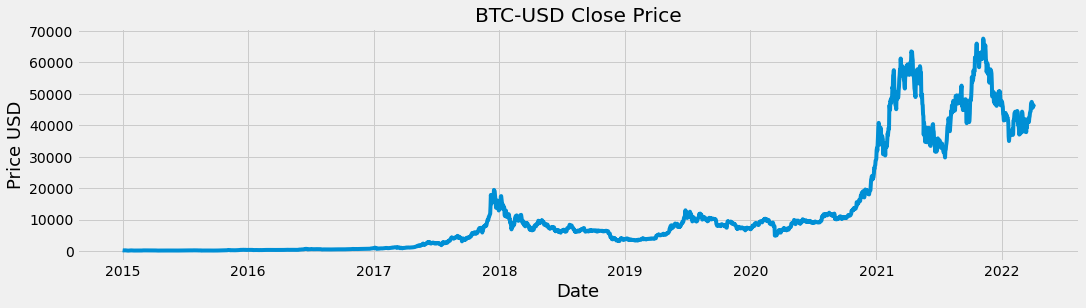

In [15]:
#Visually show the stock price
plt.figure(figsize=(16, 4))
plt.plot(df['Close'], label='Close')
plt.title(f'{company} Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.show()


In [16]:
#Calculate the On Balance Volume (OBV)
OBV = []
OBV.append(0)

#Loop through the data set (close price) from the second row (index 1) to the end of the data set
for i in range(1, len(df.Close)):
    if df.Close[i] > df.Close[i-1]:
        OBV.append(OBV[-1] + df.Volume[i])
    elif df.Close[i] < df.Close[i-1]:
        OBV.append(OBV[-1] - df.Volume[i])
    else:
        OBV.append(OBV[-1])

In [17]:
#Store the OBV and OBV Exponential Moving Average (EMA) into new columns
df['OBV'] = OBV
df['OBV_EMA'] = df['OBV'].ewm(span=20).mean()
#Show the data
df

,High,Low,Open,Close,Volume,Adj Close,OBV,OBV_EMA
Date,,,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993,0,0.000000e+00
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013,7860650,4.126841e+06
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001,-25193750,-6.639504e+06
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007,-80822850,-2.805509e+07
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999,-36860050,-3.018493e+07
...,...,...,...,...,...,...,...,...
2022-03-31,47512.027344,45390.539062,47062.148438,45538.675781,33327427106,45538.675781,1888100820539,1.821381e+12
2022-04-01,46616.242188,44403.140625,45554.164062,46281.644531,38162644287,46281.644531,1926263464826,1.831370e+12
2022-04-02,47028.281250,45782.511719,46285.500000,45868.949219,29336594194,45868.949219,1896926870632,1.837613e+12


In [18]:
def add_obv_and_obv_ema(df):
    #Calculate the On Balance Volume (OBV)
    OBV = []
    OBV.append(0)

    #Loop through the data set (close price) from the second row (index 1) to the end of the data set
    for i in range(1, len(df.Close)):
        if df.Close[i] > df.Close[i-1]:
            OBV.append(OBV[-1] + df.Volume[i])
        elif df.Close[i] < df.Close[i-1]:
            OBV.append(OBV[-1] - df.Volume[i])
        else:
            OBV.append(OBV[-1])
    
    #Store the OBV and OBV Exponential Moving Average (EMA) into new columns
    df['OBV'] = OBV
    df['OBV_EMA'] = df['OBV'].ewm(span=20).mean()
    
    return df

In [19]:
test_df = web.DataReader(company, "yahoo", start, end)
test_df = add_obv_and_obv_ema(test_df)
test_df

,High,Low,Open,Close,Volume,Adj Close,OBV,OBV_EMA
Date,,,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993,0,0.000000e+00
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013,7860650,4.126841e+06
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001,-25193750,-6.639504e+06
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007,-80822850,-2.805509e+07
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999,-36860050,-3.018493e+07
...,...,...,...,...,...,...,...,...
2022-03-31,47512.027344,45390.539062,47062.148438,45538.675781,33327427106,45538.675781,1888100820539,1.821381e+12
2022-04-01,46616.242188,44403.140625,45554.164062,46281.644531,38162644287,46281.644531,1926263464826,1.831370e+12
2022-04-02,47028.281250,45782.511719,46285.500000,45868.949219,29336594194,45868.949219,1896926870632,1.837613e+12


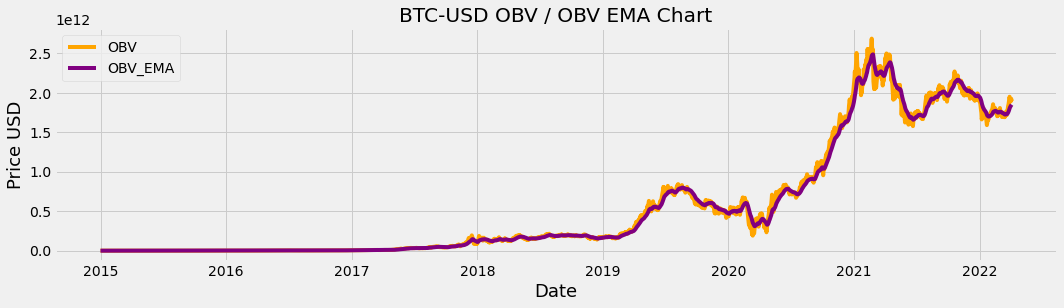

In [20]:
#Plot the buy and sell prices
plt.figure(figsize=(16, 4))
plt.plot(df['OBV'], label='OBV', color ='orange')
plt.plot(df['OBV_EMA'], label='OBV_EMA', color='purple')
plt.title(f'{company} OBV / OBV EMA Chart')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.legend()
plt.show()


In [21]:
#Create a function to signal when to buy and sell the stock
# If OBV > OBV_EMA Then Buy
# IF OBV < OBV_EMA Then Sell
# Else Do Nothing

def obv_indicator(df, col1, col2):
    sigPriceBuy, sigPriceSell = [], []
    flag = -1
    #Loop through the length of the data set
    for i in range(0, len(df)):
        # If OBV > OBV_EMA Then Buy --> col1 => 'OBV' and col2 => 'OBV_EMA'
        if df[col1][i] > df[col2][i] and flag != 1:
            sigPriceBuy.append(df['Close'][i])
            sigPriceSell.append(np.nan)
            flag = 1
        # IF OBV < OBV_EMA Then Sell
        elif df[col1][i] < df[col2][i] and flag != 0:
            sigPriceSell.append(df['Close'][i])
            sigPriceBuy.append(np.nan)
            flag = 0
        else:
            sigPriceSell.append(np.nan)
            sigPriceBuy.append(np.nan)
            
    return (sigPriceBuy, sigPriceSell)

In [22]:
#Create buy and sell columns
x = obv_indicator(df, 'OBV', 'OBV_EMA')
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]
#Show the data set
df

,High,Low,Open,Close,Volume,Adj Close,OBV,OBV_EMA,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993,0,0.000000e+00,NaN,NaN
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013,7860650,4.126841e+06,315.032013,NaN
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001,-25193750,-6.639504e+06,NaN,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007,-80822850,-2.805509e+07,NaN,NaN
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999,-36860050,-3.018493e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-03-31,47512.027344,45390.539062,47062.148438,45538.675781,33327427106,45538.675781,1888100820539,1.821381e+12,NaN,NaN
2022-04-01,46616.242188,44403.140625,45554.164062,46281.644531,38162644287,46281.644531,1926263464826,1.831370e+12,NaN,NaN
2022-04-02,47028.281250,45782.511719,46285.500000,45868.949219,29336594194,45868.949219,1896926870632,1.837613e+12,NaN,NaN


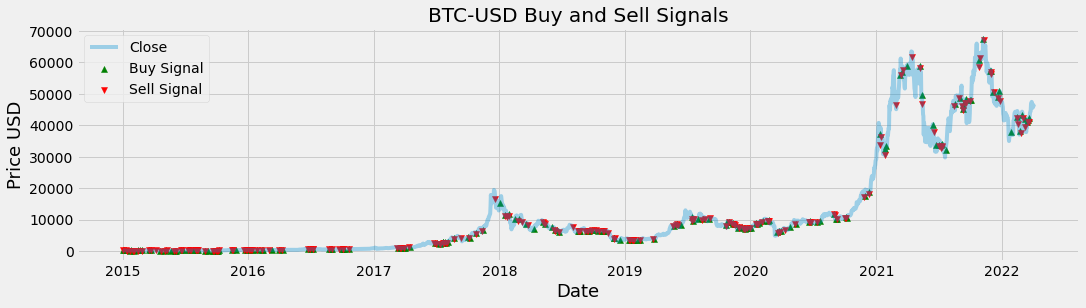

In [23]:
#Plot the buy and sell prices
plt.figure(figsize=(16, 4))
plt.plot(df['Close'], label='Close', alpha = 0.35)
plt.scatter(df.index, df['Buy_Signal_Price'], label='Buy Signal', marker = '^', alpha= 1, color='green')
plt.scatter(df.index, df['Sell_Signal_Price'], label='Sell Signal', marker = 'v', alpha=1, color='red')
plt.title(f'{company} Buy and Sell Signals')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD', fontsize=18)
plt.legend()
plt.show()

In [24]:
fct_df = web.DataReader(company, "yahoo", start, end)
fct_df = stock.on_balance_volume(fct_df)
fct_df = stock.obv_indicator(fct_df, 'OBV', 'OBV_EMA')
fct_df

,High,Low,Open,Close,Volume,Adj Close,OBV,OBV_EMA,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993,0,0.000000e+00,NaN,NaN
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013,7860650,4.126841e+06,315.032013,NaN
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001,-25193750,-6.639504e+06,NaN,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007,-80822850,-2.805509e+07,NaN,NaN
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999,-36860050,-3.018493e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-03-31,47512.027344,45390.539062,47062.148438,45538.675781,33327427106,45538.675781,1888100820539,1.821381e+12,NaN,NaN
2022-04-01,46616.242188,44403.140625,45554.164062,46281.644531,38162644287,46281.644531,1926263464826,1.831370e+12,NaN,NaN
2022-04-02,47028.281250,45782.511719,46285.500000,45868.949219,29336594194,45868.949219,1896926870632,1.837613e+12,NaN,NaN
